In [1]:
!pip install pmdarima statsmodels matplotlib pandas numpy scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 27.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pmdarima as pm


In [3]:
np.random.seed(42)

periods = 120
time_index = pd.date_range("2015-01-01", periods=periods, freq="M")

trend = np.linspace(50, 120, periods)
season = 10 * np.sin(2 * np.pi * time_index.month / 12)
noise = np.random.normal(0, 5, periods)

ts = trend + season + noise

data = pd.DataFrame({"Date": time_index, "Value": ts})
data.set_index("Date", inplace=True)

data.head()


/tmp/ipython-input-1529847735.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_index = pd.date_range("2015-01-01", periods=periods, freq="M")


Value
Date                 
2015-01-31  57.483571
2015-02-28  58.557168
2015-03-31  64.414913
2015-04-30  68.040109
2015-05-31  56.182174

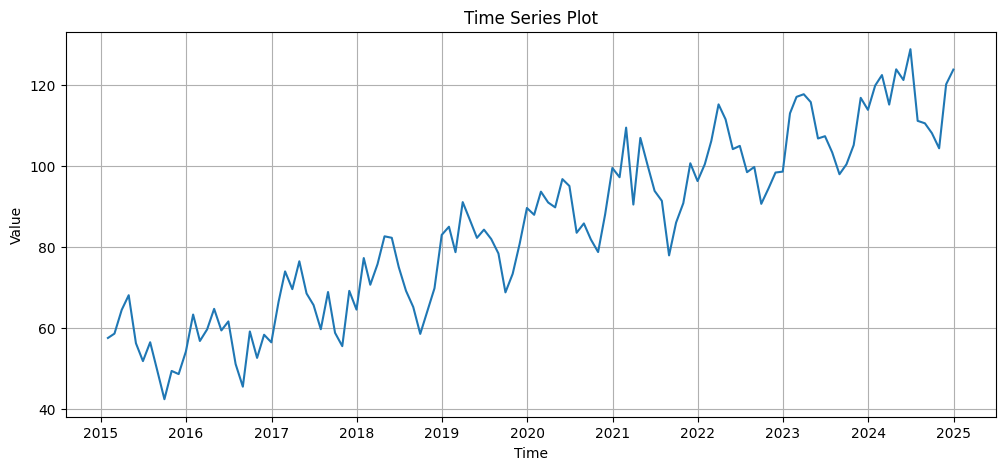

In [4]:
plt.figure(figsize=(12,5))
plt.plot(data.Value)
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()


In [5]:
data.Value = data.Value.interpolate()


In [6]:
z = np.abs((data.Value - data.Value.mean()) / data.Value.std())
data["Value_clean"] = np.where(z > 3, data.Value.median(), data.Value)


In [8]:
adf = adfuller(data.Value_clean)
print("ADF Statistic:", adf[0])
print("p-value:", adf[1])

if adf[1] < 0.05:
    print("Series is Stationary")
else:
    print("Series is NOT Stationary — Differencing Needed")


ADF Statistic: 0.7970160607048777
p-value: 0.9915878486557315
Series is NOT Stationary — Differencing Needed


In [9]:
data["Value_diff"] = data.Value_clean.diff().dropna()


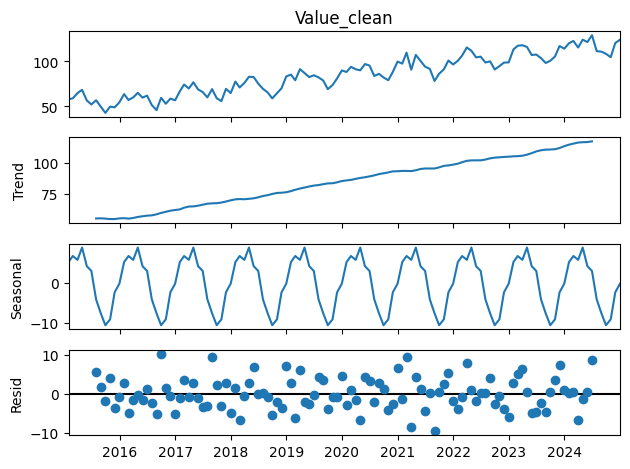

In [10]:
decomp = seasonal_decompose(data.Value_clean, model="additive", period=12)
decomp.plot()
plt.show()


In [11]:
train = data.Value_clean[:-12]
test = data.Value_clean[-12:]


In [12]:
model = pm.auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True,
    error_action="ignore",
    suppress_warnings=True
)

model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=729.355, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=721.949, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=723.940, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=727.930, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=727.213, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=718.165, Time=1.31 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=730.520, Time=1.27 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=715.165, Time=0.75 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=722.525, Time=0.29 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(3,1,0)(2,0,0)[12] intercept   : AIC=716.181, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 12)   Log Likelihood                -345.655
Date:                             Thu, 20 Nov 2025   AIC                            699.310
Time:                                     11:16:13   BIC                            710.002
Sample:                                 01-31-2015   HQIC                           703.644
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8470      0.065    -12.966      0.000      -0.975      -0.719
ar.S.L12       0.3855      0.085      4.557      0.000       0.220       0.551
ar.S.L24       0.4329      0.096      4.499      0.000       0.244       0.621
sigma2        32.9922      4.317      7.643      0.000      24.531      41.453
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.75   Prob(JB):                         0.80
Heteroskedasticity (H):               1.37   Skew:                             0.08
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
forecast = model.predict(n_periods=12)
forecast = pd.Series(forecast, index=test.index)


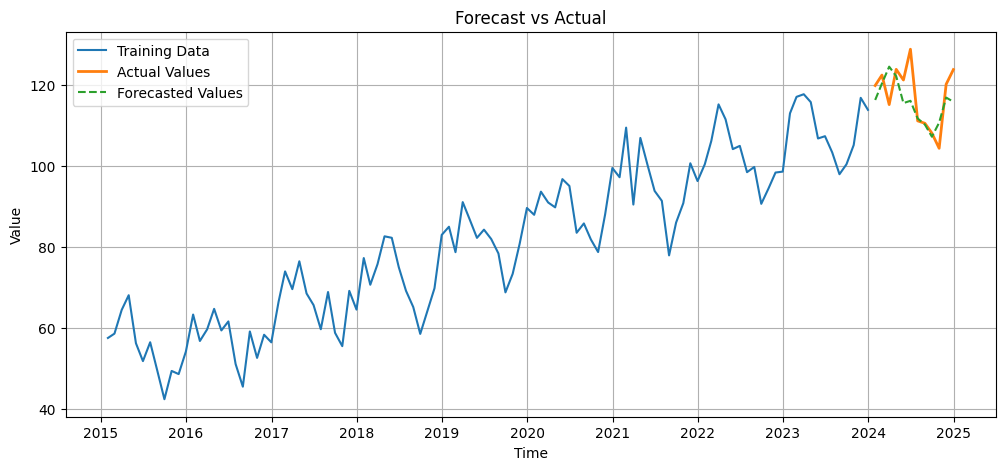

In [14]:
plt.figure(figsize=(12,5))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Values', linewidth=2)
plt.plot(forecast, label='Forecasted Values', linestyle="--")
plt.title("Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape, "%")


MAE: 4.540299619225684
MSE: 34.80369079593648
RMSE: 5.899465297460142
MAPE: 3.8020344774288244 %


/tmp/ipython-input-4151972480.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(test.index[-1], periods=25, freq="M")[1:]


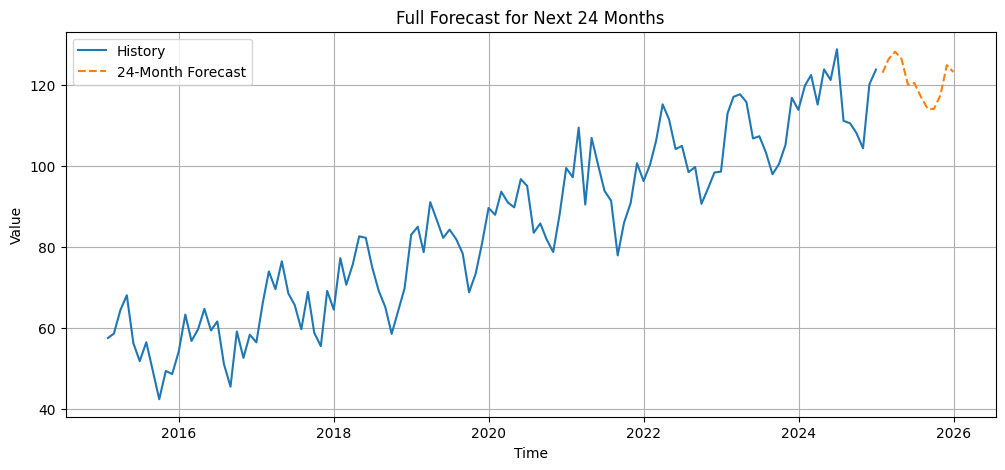

In [16]:
future = model.predict(n_periods=24)
future_index = pd.date_range(test.index[-1], periods=25, freq="M")[1:]

future_series = pd.Series(future, index=future_index)

plt.figure(figsize=(12,5))
plt.plot(data.Value_clean, label="History")
plt.plot(future_series, label="24-Month Forecast", linestyle="--")
plt.title("Full Forecast for Next 24 Months")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
